In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from functools import reduce
from pandasql import sqldf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

pysqldf = lambda q: sqldf(q, globals())

import os

path = os.getcwd() + r'/archive' # use your path
# print(path)
# all_files = glob.glob(os.path.join(path , "/*.csv"))
# print(all_files)


directory = ""
li = []

for filename in sorted(os.listdir(path)):
    if(filename == "merged_data.csv"):
        continue
    file = os.path.join(path, filename)
    df = pd.read_csv(file)
    li.append(df)
print(len(li))

9


In [47]:
df_customers, df_geolocation, df_order_items, df_order_payments, df_order_reviews, df_orders, df_products, df_sellers, df_category_name_translation = li
print(df_customers)

                            customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0  

In [48]:
order_customers = [df_orders, df_customers]
merged_orders_customers = reduce(lambda left, right: pd.merge(left, right, on=["customer_id"], how="inner"), order_customers)
order_customers_items = [merged_orders_customers, df_order_items]
merged_orders_customers_items = reduce(lambda left, right: pd.merge(left, right, on=["order_id"], how='inner'), order_customers_items)
order_customers_items_products = [merged_orders_customers_items, df_products]
merged_orders_customers_items_products = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how='inner'), order_customers_items_products)
order_customers_items_products_names = [merged_orders_customers_items_products, df_category_name_translation]
merged_orders_customers_items_products_names = reduce(lambda left, right: pd.merge(left, right, on=["product_category_name"], how='inner'), order_customers_items_products_names)


In [49]:
df_aggregate_product = pd.DataFrame(merged_orders_customers_items_products_names['product_id'].unique(), columns=["product_id"])

q = pysqldf("""
    SELECT product_id, AVG(review_score) as average_score FROM merged_orders_customers_items_products_names NATURAL JOIN df_order_reviews GROUP BY 1
    HAVING COUNT(product_id) > 50
""")
df_aggregate_product = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how="inner"), [df_aggregate_product, q])

q = pysqldf("""
    SELECT product_id, COUNT(product_id) as times_bought FROM merged_orders_customers_items GROUP BY product_id
""")
df_aggregate_product = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how="inner"), [df_aggregate_product, q])
print(df_aggregate_product)


                           product_id  average_score  times_bought
0    42a2c92a0979a949ca4ea89ec5c7b934       4.000000           183
1    e9a69340883a438c3f91739d14d3a56d       4.000000            58
2    30ac6df06dc59ad72cf2f158fc2d904c       3.944444            55
3    d696750e550fd0f733979dd7e5dff921       4.526316            57
4    5a6e53c3b4e8684b13388d6aa4afdf12       4.164384            73
..                                ...            ...           ...
163  35afc973633aaeb6b877ff57b2793310       3.820359           165
164  0aabfb375647d9738ad0f7b4ea3653b1       4.204225           142
165  6c3effec7c8ddba466d4f03f982c7aa3       3.894737            97
166  cd48f265a63e13b762601f5f794c5fca       4.236559            93
167  4fe644d766c7566dbc46fb851363cb3b       3.754717           107

[168 rows x 3 columns]


Text(0, 0.5, 'Times Bought')

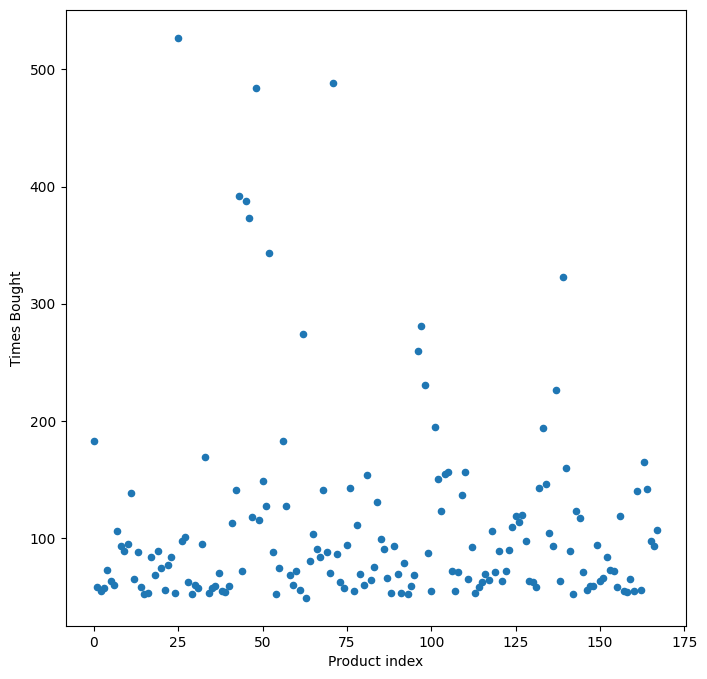

In [50]:
products_bought_graph = df_aggregate_product.iloc[:500].reset_index().plot(x='index', y='times_bought', kind='scatter', figsize=(8,8))
products_bought_graph.set_xlabel("Product index")
products_bought_graph.set_ylabel("Times Bought")


Text(0, 0.5, 'Review Score')

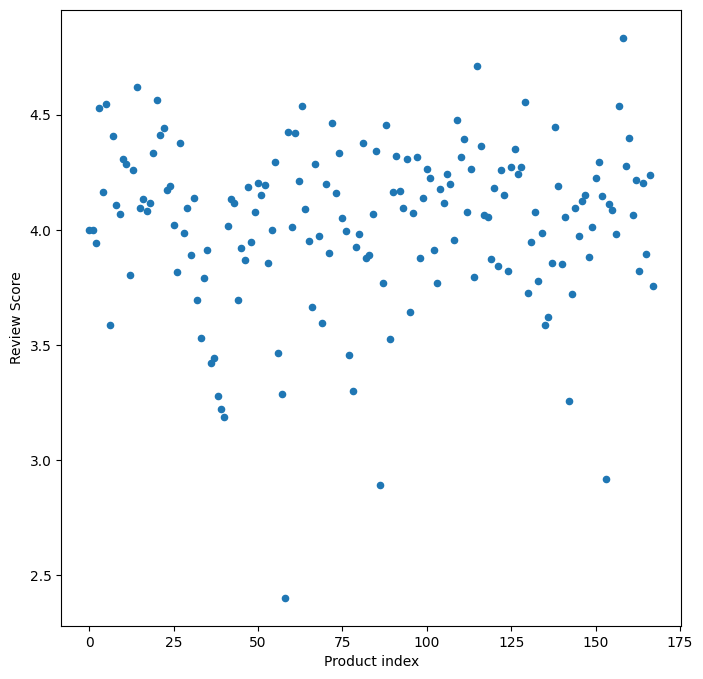

In [51]:

products_review_graph = df_aggregate_product.iloc[:500].reset_index().plot(x='index', y='average_score', kind='scatter', figsize=(8,8))
products_review_graph.set_xlabel("Product index")
products_review_graph.set_ylabel("Review Score")

In [52]:
merged_orders_customers_items_products_names = merged_orders_customers_items_products_names.drop(columns=["order_status", "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "customer_zip_code_prefix", "customer_city", "order_item_id", "seller_id", "shipping_limit_date", "price", "freight_value", "product_category_name", "product_name_lenght", "product_description_lenght", "product_photos_qty", "product_weight_g", "product_length_cm", "product_width_cm", "product_height_cm", "customer_id"])
merged_orders_customers_items_products_names.to_csv(os.path.join(path, "merged_data.csv"), index=False)

In [53]:
df_filtered = merged_orders_customers_items_products_names[['customer_unique_id', 'product_category_name_english', 'product_id']]
# print(df_filtered)

# df_table.head()
# X = pd.get_dummies(df_filtered['product_category_name_english'])
# y = pd.get_dummies(df_filtered['product_id']).to_numpy()
y = pd.Categorical(df_filtered['product_category_name_english']).codes
y = pd.DataFrame(y, columns=['product_category_name_english'])
df_filtered = df_filtered.drop('product_category_name_english', axis=1);
df_filtered = df_filtered.join(y);
y = pd.Categorical(df_filtered['customer_unique_id']).codes
y = pd.DataFrame(y, columns=['customer_unique_id'])
df_filtered = df_filtered.drop('customer_unique_id', axis=1);
df_filtered = df_filtered.join(y);
print(df_filtered)
df_table = df_filtered.pivot_table(index="product_id", columns="product_category_name_english").fillna(0);
df_table.head()


df_matrix = csr_matrix(df_table.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(df_matrix)

q = 103
distances, indices = model_knn.kneighbors(df_table.iloc[q,:].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df_table.index[0]))
        row = merged_orders_customers_items_products_names.loc[merged_orders_customers_items_products_names['product_id'] == df_table.index[indices.flatten()[0]]]
        print(row['product_category_name_english'].unique()[0])
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, df_table.index[indices.flatten()[i]], distances.flatten()[i]))
        row = merged_orders_customers_items_products_names.loc[merged_orders_customers_items_products_names['product_id'] == df_table.index[indices.flatten()[i]]]
        print(row['product_category_name_english'].unique()[0])

                              product_id  product_category_name_english  \
0       87285b34884572647811a353c7ac498a                             49   
1       87285b34884572647811a353c7ac498a                             49   
2       87285b34884572647811a353c7ac498a                             49   
3       87285b34884572647811a353c7ac498a                             49   
4       be021417a6acb56b9b50d3fd2714baa8                             49   
...                                  ...                            ...   
111018  4a24717893a6c8f3cfcf9843b8987d15                              3   
111019  9c313adb4b38a55b092f53f83f78be9e                              3   
111020  eacb104882d39ffb53140b1d1860a7c3                              3   
111021  6c7a0a349ad11817745e3ad58abd5c79                             61   
111022  8db75af9aed3315374db44d7860e25da                             61   

        customer_unique_id  
0                    45758  
1                    21530  
2           

Text(0, 0.5, 'Times Bought')

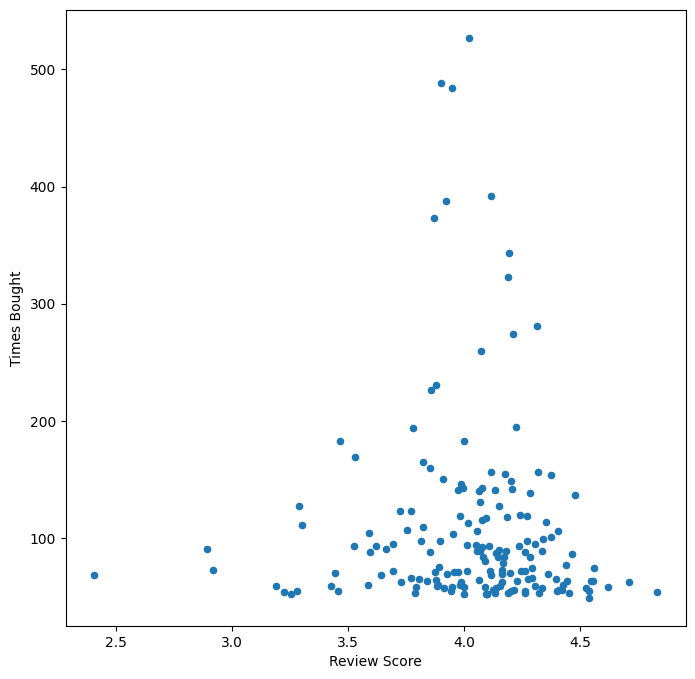

In [54]:
products_review_bought_graph = df_aggregate_product.iloc[:500].reset_index().plot(x='average_score', y='times_bought', kind='scatter', figsize=(8,8))
products_review_bought_graph.set_xlabel("Review Score")
products_review_bought_graph.set_ylabel("Times Bought")

In [57]:
df_aggregate_category = pd.DataFrame(merged_orders_customers_items_products_names['product_category_name_english'].unique(), columns=["product_category_name_english"])
q = pysqldf("""
    SELECT product_category_name_english, COUNT(product_category_name_english) AS occurences FROM merged_orders_customers_items_products_names GROUP BY 1
""")
df_aggregate_category = reduce(lambda left, right: pd.merge(left, right, on=["product_category_name_english"], how="inner"), [df_aggregate_category, q])

   product_category_name_english  occurences
0     agro_industry_and_commerce         212
1               air_conditioning         297
2                            art         209
3          arts_and_craftmanship          24
4                          audio         364
..                           ...         ...
66                    stationery        2517
67        tablets_printing_image          83
68                     telephony        4545
69                          toys        4117
70                 watches_gifts        5991

[71 rows x 2 columns]
   product_category_name_english  occurences
0                     housewares        6964
1                      perfumery        3419
2                           auto        4235
3                       pet_shop        1947
4                     stationery        2517
..                           ...         ...
66                books_imported          60
67     fashion_childrens_clothes           8
68                         music

<AxesSubplot: xlabel='product_category_name_english'>

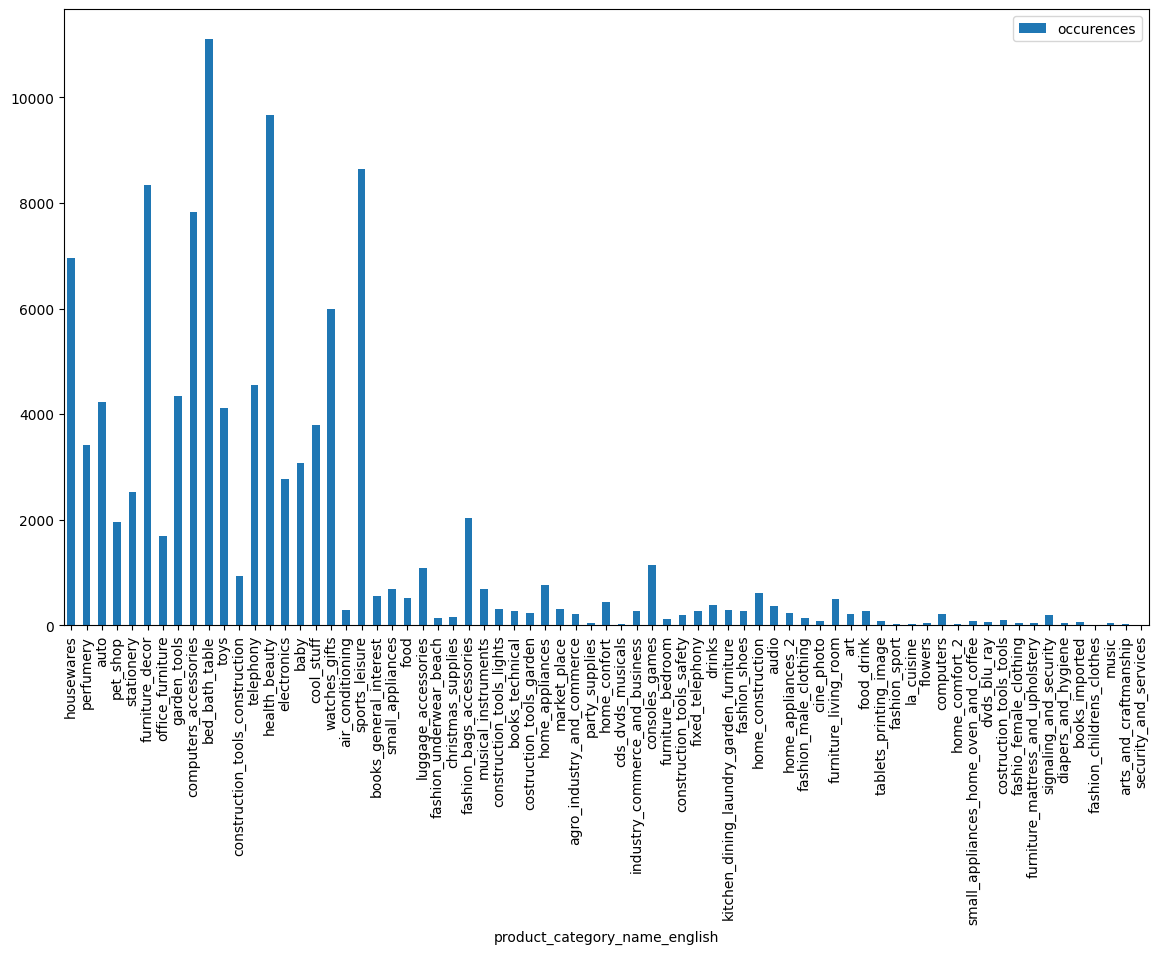

In [63]:
df_aggregate_category.iloc[:500].plot(x="product_category_name_english", y="occurences", kind="bar", figsize = (14,8))